In [1]:
# Numpy for matrix math 
import numpy as np
# matplotlib pyplot for visualizations
import matplotlib.pyplot as plt
# Abstract Base Class
from abc import ABC, abstractmethod
# pip install mnist for the dataset
import mnist

# Lets grab MNIST images
train_images = mnist.train_images()
train_labels = mnist.train_labels()
test_images = mnist.test_images()
test_labels = mnist.test_labels()

MOMENTUM = .9

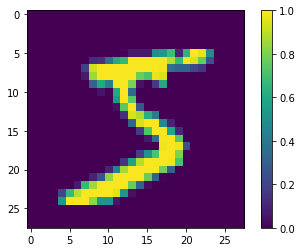

In [2]:
train_images, test_images = [img / train_images.max() for img in [train_images, test_images]]
plt.imshow(train_images[0,:,:])
plt.colorbar()
plt.show()

In [15]:

def l2_loss(y, yhat):
    loss_matrix = np.square(yhat - y)
    loss_gradient = 2 * (yhat - y)
    return loss_matrix, loss_gradient

def get_one_hot(targets, n_classes):
    res = np.eye(n_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[n_classes])

def apply_linear_momentum(prev_momentum, grad_parameter, momentum):
    # Calculate momentum update by linear momentum method
    assert momentum <= 1 and momentum >= 0

    return prev_momentum * momentum + grad_parameter * (1 - momentum)


class Layer(ABC):
    @abstractmethod
    def __init__(self, **args):
        pass

    @abstractmethod
    def forward(self, x):
        # Forward propagate. Remember params needed for backprop
        pass

    @abstractmethod
    def backward(self, x):
        # Return gradient to input, gradient to parameters
        pass

    def step(self, learning_rate):
        pass


class Lrelu(Layer):
    def __init__(self, input_layer=None, in_size=None):
        self.out_size = input_layer if input_layer is not None else in_size

    def forward(self, x):
        return np.maximum(x, x * .1)

    def backward(self, out_grad):
        grad_back = np.where(out_grad > 0, out_grad, out_grad * .1)
        return grad_back


class Linear(Layer):
    def __init__(self, input_layer=None, in_size=None, out_size=None):
        self.in_size = input_layer if input_layer is not None else in_size
        self.out_size = out_size
        self.w = np.random.randn(in_size, out_size)
        self.vel = np.zeros((in_size, out_size))

    def forward(self, x):
        self.prev_input = x
        return np.matmul(x, self.w)

    def backward(self, out_grad):
        # in_size, BS * BS, out_size = in_size, out_size
        raw_grad_w = np.matmul(self.prev_input.T, out_grad)
        self.grad_w = np.clip(raw_grad_w, -1, 1)

        # BS, out_size * out_size, in_size = BS, in_size
        return np.matmul(out_grad, self.w.T)

    def step(self, learning_rate):
        self.vel = apply_linear_momentum(self.vel, self.grad_w, MOMENTUM)
        self.w = self.w - self.vel * learning_rate


class MultiLayerPerceptron():
    def __init__(self, layers, loss_fcn):
        self.layers = layers
        self.loss_fcn = loss_fcn

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        yhat = x
        return yhat

    def backward(self, loss_gradient):
        for layer in self.layers[::-1]:
            loss_gradient = layer.backward(loss_gradient)

    def loss(self, y, yhat):
        loss_matrix, loss_gradient = self.loss_fcn(y, yhat)
        return loss_matrix, loss_gradient

    def step(self, learning_rate):
        for layer in self.layers:
            layer.step(learning_rate)
    
    def get_accuracy(self, x, y):
        yhat = self.forward(x)
        predictions = np.argmax(yhat, 1)
        return (predictions == y).mean()


class Trainer():
    def __init__(self, model):
        self.model = model
        self.train_accuracies = []
        self.val_accuracies = []
        self.steps = 0

    def optimize(self, x, y, learning_rate):
        model = self.model
        yhat = model.forward(x)
        _, loss_gradient = model.loss(y, yhat)
        model.backward(loss_gradient)
        model.step(learning_rate)

    def train_n_steps(self, x_train, train_labels, x_test, test_labels, n, bs, val_every_n):
        y_train = get_one_hot(train_labels, num_classes)
        y_test = get_one_hot(test_labels, num_classes)
        for idx in range(n):
            samples = np.random.choice(x_train.shape[0], size=bs)
            x = x_train[samples,:]
            y = y_train[samples,:]
            self.steps += 1
            self.optimize(x, y, learning_rate=1 / (self.steps + 100))
            if idx % val_every_n == 0:
                trn_acc = self.model.get_accuracy(x_train, train_labels)
                val_acc = self.model.get_accuracy(x_test, test_labels)
                self.train_accuracies.append(trn_acc)
                self.val_accuracies.append(val_acc)
        self.visualize()
        
    def visualize(self, skip_first=0):
        plt.plot(self.train_accuracies, label = 'train accuracy')
        plt.plot(self.val_accuracies, label = 'val accuracy')
        plt.legend()
        plt.title('basic mnist model approaches ' + str(self.train_accuracies[-1])[:5])
        plt.savefig('model_6_mnnist.jpg')
        plt.show()

In [16]:
x_train = np.reshape(train_images, [train_images.shape[0], -1])
x_test = np.reshape(test_images, [test_images.shape[0], -1])

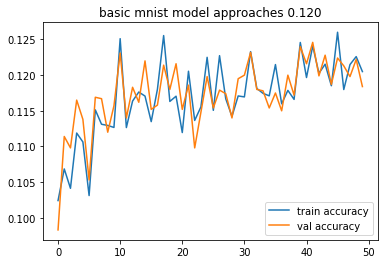

In [18]:

num_classes = len(np.unique(train_labels))
# N is number of data points; BS is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, bs, D_in, H, D_out = x_train.shape[0], 64, x_train.shape[1], 100, num_classes

sizes = [D_in, H, D_out]

layers = []
layers.append(Linear(in_size=D_in, out_size=H))
layers.append(Lrelu(in_size=H))
layers.append(Linear(in_size=H, out_size=D_out))

model = MultiLayerPerceptron(layers, loss_fcn=l2_loss)

trainer = Trainer(model)
trainer.train_n_steps(x_train = x_train, train_labels = train_labels, x_test = x_test, test_labels = test_labels,
                      n=5000, bs = bs, val_every_n = 100)


In [19]:
np.argmax(model.forward(x_train),

array([[ 0.11704288, -0.54909858, -4.27433699, ...,  1.84984385,
         3.7250286 ,  0.64133816],
       [ 1.26697949, -0.92200801,  1.64394044, ..., -0.28273998,
        -1.0281531 , -0.50805879],
       [ 2.44257338, -1.08026156,  2.12737914, ...,  3.00283342,
         1.31972841, -0.96519027],
       ...,
       [ 5.91761466,  1.27283066,  2.62526336, ...,  1.01443245,
        -2.32581779, -2.7873632 ],
       [ 0.65041927, -6.49802078, -0.64399053, ...,  1.29759281,
        -6.19310151, -5.4771352 ],
       [-0.61459721, -2.8853915 , -0.92673764, ..., -3.87033439,
        -7.02025348, -4.06922127]])